In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math,copy,time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,src_embed,tgt_embed,generator):
        super(EncoderDecoder,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=src_embed
        self.tgt_embed=tgt_embed
        self.generator=generator

    def forward(self,src,tgt,src_mask,tgt_mask):
        return self.decode(self.encode(src,src_mask),src_mask,
                           tgt,tgt_mask)
        
    def encode(self,src,src_mask):
        return self.encoder(self.src_embed(src),src_mask)

    def decode(self,memory,src_mask,tgt,tgt_mask):
        return self.decoder(self.tgt_embed(tgt),memory,src_mask,tgt_mask)

In [3]:
class Generator(nn.Module):
    "由linear和softmax组成"
    def __init__(self,d_model,vocab):
        super(Generator,self).__init__()
        self.proj=nn.Linear(d_model,vocab)

    def forward(self,x):
        return F.log_softmax(self.proj(x),dim=-1)

# Encoder部分和Decoder部分 #

In [5]:
def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)

    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

In [7]:
class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2=nn.Parameter(torch.ones(features))
        self.b_2=nn.Parameter(torch.zeros(features))
        self.eps=eps

    def forward(self,x):
        mean=x.mean(-1,keepdim=True)
        std=x.std(-1,keepdim=True)
        return self.a_2*(x-mean)/(std+self.eps)+self.b_2

In [8]:
class SublayerConnection(nn.Module):
    def __init__(self,size,dropout):
        super(SublayerConnection,self).__init__()
        self.norm=LayerNorm(size)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn=self_attn
        self.feed_forward=feed_forward
        self.size=size
        self.sublayer=clones(SublayerConnection(size,dropout),2)

    def forward(self,x,mask):
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)        

In [10]:
class Decoder(nn.Module):
    def __init__(self,layer,N):
        super(Decoder,self).__init__()
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)

    def forward(self,x,memory,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,memory,src_mask,tgt_mask)
        return self.norm(x)

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super(DecoderLayer,self).__init__()
        self.size=size
        self.self_attn=self_attn
        self.src_attn=src_attn
        self.feed_forward=feed_forward
        self.dropout=dropout
        self.sublayer=clones(SublayerConnection(size,dropout),3)

    def forward(self,x,memory,src_mask,tgt_mask):
        m=memory
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,tgt_mask))
        x=self.sublayer[1](x,lambda x:self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x,self.feed_forward)

In [12]:
def subsequent_mask(size):
    attn_shape=(1,size,size)
    subsequent_mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask)==0

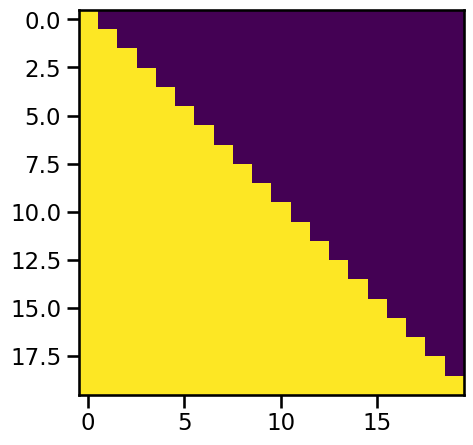

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])


In [14]:
def attention(query,key,value,mask=None,dropout=None):
    d_k=query.size(-1)
    scores=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
        scores=scores.masked_fill(mask==0,-1e9)
    p_attn=F.softmax(scores,dim=-1)
    if dropout is not None:
        p_attn=dropout(p_attn)
    return torch.matmul(p_attn,value),p_attn

In [15]:
torch.manual_seed(0)
batch_size=2
seq_len=5
d_k=d_v=4
query=torch.randn(batch_size,seq_len,d_k)
key=torch.randn(batch_size,seq_len,d_k)
value=torch.randn(batch_size,seq_len,d_k)


output, attention_weights = attention(query, key, value)
attention_weights

tensor([[[0.2438, 0.0547, 0.3700, 0.3207, 0.0108],
         [0.2622, 0.5394, 0.1480, 0.0162, 0.0342],
         [0.2813, 0.1022, 0.1619, 0.2904, 0.1642],
         [0.0424, 0.2734, 0.0755, 0.0628, 0.5458],
         [0.0945, 0.0180, 0.1830, 0.6765, 0.0280]],

        [[0.0794, 0.5617, 0.1799, 0.1139, 0.0651],
         [0.1226, 0.2171, 0.3213, 0.1465, 0.1925],
         [0.0969, 0.2468, 0.2889, 0.1679, 0.1994],
         [0.1933, 0.4131, 0.0443, 0.1900, 0.1593],
         [0.3358, 0.1034, 0.4206, 0.1133, 0.0269]]])

In [16]:
class MultiHeadedAttention(nn.Module):
    def __init__(self,h,d_model,dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        assert d_model%h==0
        self.h=h
        self.d_k=d_model//h
        self.attn=None
        self.linears=clones(nn.Linear(d_model,d_model),4)
        self.dropout=nn.Dropout(p=dropout)

    def forward(self,query,key,value,mask=None):
        n_batch=query.size(0)
        if mask is not None:
            mask=mask.unsqueeze(1)

        query,key,value=[l(x).view(n_batch,-1,self.h,self.d_k).transpose(1,2) for l,x in zip(self.linears,(query,key,value))]

        x,self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)

        x=x.transpose(1,2).contiguous().view(n_batch,-1,self.h*self.d_k)
        return self.linears[-1](x)

In [17]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w_1=nn.Linear(d_model,d_ff)
        self.w_2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [18]:
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
        super(Embeddings,self).__init__()
        self.lut=nn.Embedding(vocab,d_model)
        self.d_model=d_model

    def forward(self,x):
        return self.lut(x)* math.sqrt(self.d_model)

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(dropout)

        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len).unsqueeze(1)

        div_term=torch.exp(torch.arange(0,d_model,2)*-(math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)

    def forward(self,x):
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)
        

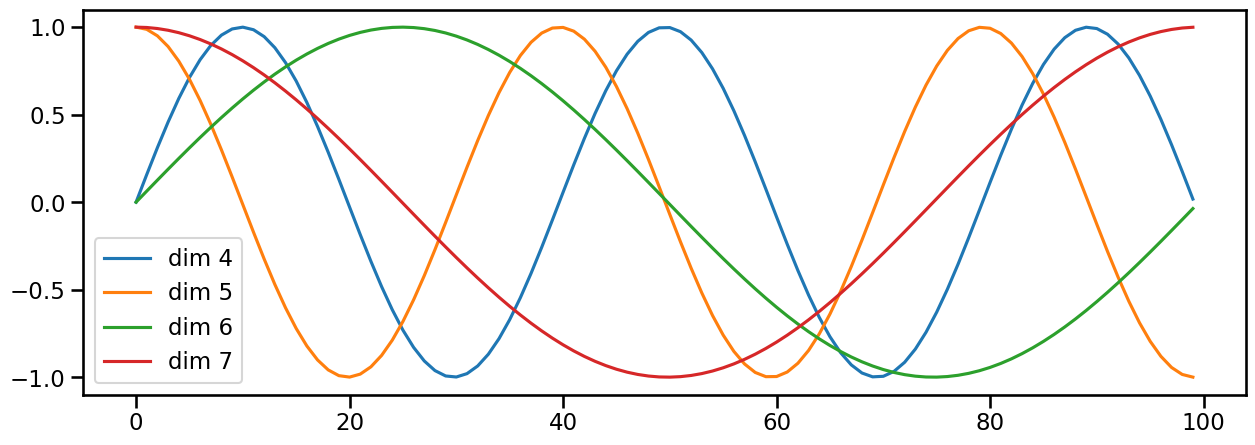

In [20]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])


# 完成模型

In [22]:
def make_model(src_vocab,tgt_vocab,N=6,d_model=512,d_ff=2048,h=8,dropout=0.1):
    c=copy.deepcopy
    attn=MultiHeadedAttention(h,d_model)
    ff=PositionwiseFeedForward(d_model,d_ff,dropout)
    position=PositionalEncoding(d_model,dropout)
    model=EncoderDecoder(
        Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
        Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
        nn.Sequential(Embeddings(d_model,src_vocab),c(position)),
        nn.Sequential(Embeddings(d_model,tgt_vocab),c(position)),
        Generator(d_model,tgt_vocab)
    )
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

# 构建训练参数

In [24]:
# Small example model.
tmp_model = make_model(10, 10, 2)
print(tmp_model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

In [25]:
import torch
import torch.nn as nn

# 假设我们已经定义了 tmp_model，且其为 EncoderDecoder 的实例

# 模型超参数
src_vocab_size = 10   # 源语言词汇表大小
tgt_vocab_size = 10   # 目标语言词汇表大小
d_model = 512         # 嵌入维度
num_layers = 2        # 编码器和解码器层数
num_heads = 8         # 注意力头数

# 假设输入数据为
src = torch.randint(0, src_vocab_size, (16, 10))  # 输入序列 (batch_size=16, seq_length=10)
tgt = torch.randint(0, tgt_vocab_size, (16, 10))  # 目标序列 (batch_size=16, seq_length=10)

# 在不使用掩蔽的情况下进行前向传播
with torch.no_grad():  # 在评估模式下禁用梯度计算
    output = tmp_model(src, tgt,None, None)  # 假设不使用 mask

# 输出结果
print("Output shape:", output.shape)  # 输出形状
print("Output:", output)                # 打印输出

Output shape: torch.Size([16, 10, 512])
Output: tensor([[[-1.7079, -1.7381, -0.1468,  ...,  0.4692,  0.1413,  1.0161],
         [-1.3391, -1.4454,  0.7363,  ..., -0.4613,  0.7154,  1.1664],
         [ 0.0556, -0.1013,  0.4088,  ...,  0.2824, -0.1372,  0.0041],
         ...,
         [-0.4280, -0.3996, -1.5492,  ...,  1.5891, -0.5124,  0.2404],
         [-1.3321, -0.7245, -1.0463,  ...,  1.6626, -0.8711, -0.0284],
         [-0.5922, -2.8480,  0.3335,  ...,  0.0959, -0.0109,  0.8985]],

        [[-1.2216, -0.4697, -0.7442,  ...,  0.8018,  0.2384,  0.2955],
         [ 0.4638, -0.0992, -0.1468,  ...,  0.4910,  0.1455, -0.7326],
         [-0.1607, -0.8652,  0.1954,  ...,  0.2642,  0.0581, -0.2609],
         ...,
         [-2.7137,  0.8167, -0.1080,  ..., -0.1449, -0.9247,  0.3701],
         [-1.9402, -0.9915,  0.3451,  ..., -0.3775,  0.8856,  0.3181],
         [-2.3832, -0.7932,  0.0410,  ..., -0.4804,  1.2481,  0.0388]],

        [[-1.3142,  0.1404,  0.6892,  ...,  1.7277, -0.7215, -0.0210

### 批处理和掩码

In [27]:
class Batch:
    def __init__(self,src,trg=None,pad=0):
        self.src=src
        self.src_mask=(src!=pad).unsqueeze(-2)
        if trg is not None:
            self.trg=trg[:,:-1]
            self.trg_y=trg[:,1:]
            self.trg_mask=self.make_std_mask(self.trg,pad)
            self.ntokens=(self.trg_y!=pad).data.sum()

    @staticmethod
    def make_std_mask(trg,pad):
        trg_mask=(trg!=pad).unsqueeze(-2)
        trg_mask=trg_mask & Variable(subsequent_mask(trg.size(-1)).type_as(trg_mask.data))
        return trg_mask

### Training Loop

In [29]:
def run_epoch(data_iter,model,loss_compute):
    start=time.time()
    total_tokens=0
    total_loss=0
    tokens=0
    for i,batch in enumerate(data_iter):
        out=model.forward(batch.src,batch.trg,batch.src_mask,batch.trg_mask)
        loss = loss_compute(out,batch.trg_y,batch.ntokens)
        total_loss+=loss
        total_tokens=batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens
            
        

In [30]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [31]:

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

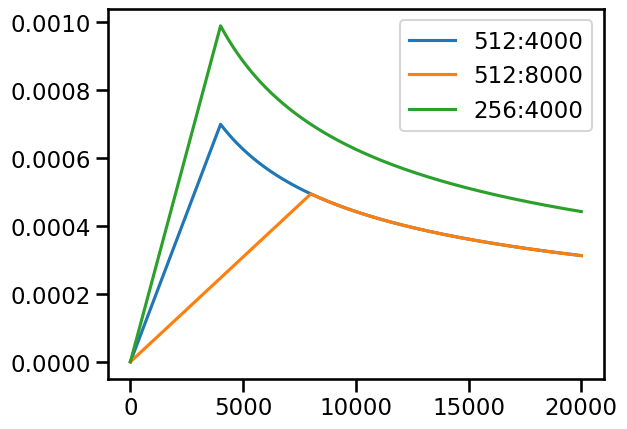

In [32]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [33]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/Applications/anaconda/anaconda3/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


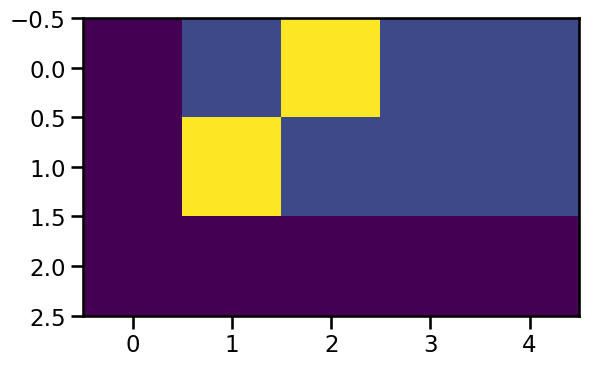

In [34]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [35]:
print(crit.true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


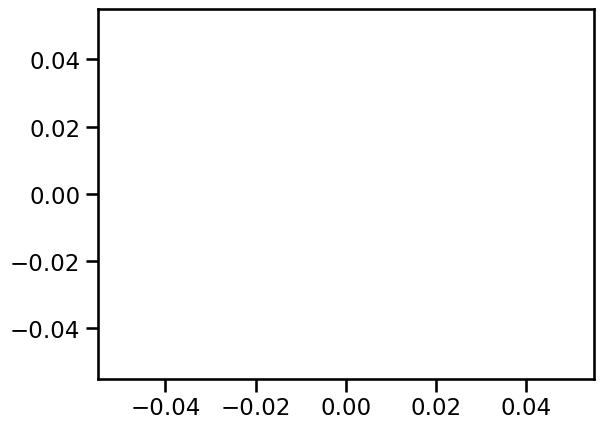

In [36]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()

y = [loss(x) for x in range(1, 100)]
x = np.arange(1, 100)
plt.plot(x, y)

In [37]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [38]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [39]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 3.029240 Tokens per Sec: 2621.182129
Epoch Step: 1 Loss: 1.979756 Tokens per Sec: 4850.225098
tensor(9.5802)
Epoch Step: 1 Loss: 1.979900 Tokens per Sec: 3413.616211
Epoch Step: 1 Loss: 1.645015 Tokens per Sec: 4930.597656
tensor(8.3101)
Epoch Step: 1 Loss: 1.880480 Tokens per Sec: 3403.567139
Epoch Step: 1 Loss: 1.444974 Tokens per Sec: 4884.628906
tensor(7.2507)
Epoch Step: 1 Loss: 1.578976 Tokens per Sec: 3465.910645
Epoch Step: 1 Loss: 1.207800 Tokens per Sec: 4872.942383
tensor(6.1196)
Epoch Step: 1 Loss: 1.260455 Tokens per Sec: 3194.943359
Epoch Step: 1 Loss: 1.247345 Tokens per Sec: 4947.539551
tensor(5.9688)
Epoch Step: 1 Loss: 1.391680 Tokens per Sec: 3097.112061
Epoch Step: 1 Loss: 0.523031 Tokens per Sec: 4961.998535
tensor(2.7803)
Epoch Step: 1 Loss: 0.785383 Tokens per Sec: 3310.832764
Epoch Step: 1 Loss: 0.411431 Tokens per Sec: 4806.878418
tensor(1.5398)
Epoch Step: 1 Loss: 1.047219 Tokens per Sec: 3250.950439
Epoch Step: 1 Loss: 0.428426 Tokens per 

In [40]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
